# Planning with Diffusion, on High-dimensional Space

Written by Simo Ryu, Hyunsik Oh, Moonkyu Jung, Taegyu Song
(류시모, 오현식, 정문규, 송태규)


> Technical Report based on the experiments inspired by the paper: [Planning with Diffusion for Flexible Behavior Synthesis](https://arxiv.org/abs/2205.09991), by Michael Janner, Yilun Du, Joshua B. Tenenbaum and Sergey Levine

# 0. Abstract

Planning with diffusion models has garnered significant attention in the field of continuous action-space planning [1, 2, 3, 4]. However, implementing diffusion models from scratch for environments with high-dimensional action-observation spaces can be exceptionally challenging. Moreover, the current landscape lacks easily understandable tutorials for diffusion planners. Our goal with this technical report is to provide a more accessible and practical approach to planning with diffusion models, specifically focusing on trajectory planning.

In this report, we will cover the following topics:

1. An overview of diffusion models and their relevance in reinforcement learning (RL) planning.
2. The challenges associated with planning using diffusion models and their implementation.
3. Proposed solutions to address these challenges and improve the effectiveness of diffusion planners.

# 1. Introduction

## 1.1 What are Diffusion Models?

Diffusion models are a class of generative models that utilize Langevin dynamics. While nonlinear and complex generative modeling can be challenging, diffusion models offer a more flexible approach compared to traditional models such as VAEs and GANs. Unlike Gaussian-parameterized VAEs (thus, suffers from multi-modality) or difficult-to-train GANs, diffusion models provide improved diversity and fidelity in generating samples, with extremely stable training process. For detailed and rather extensive overview of diffusion models, we recommend the incredible [blog by Lilian Weng](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

## 1.2 Why Use Diffusion Models in context of Reinforcement Learning?

In the context of RL planning, diffusion models offer several advantages. The planning pipeline typically involves two steps [10, 11]:

1. Training a dynamic model of the environment.
2. Maximizing a cumulative objective function 𝓙, often represented as the discounted sum of rewards or another environment-specific objective:

$$
\max_{a_0, a_1, \cdots} r(s_0, a_0) + r(f(s_0, a_0), a_1) + \cdots
$$

However, the combination of behavior cloning or offline RL (for step 1) and maximizing the objective function (step 2) can lead to challenges:

* Dynamics models have limitations, and long trajectories often suffer from accumulating errors and diverge from the true distribution [8, 9, 12].
* Balancing the objective function with the constraints of the dynamic predictor can be challenging and adversarial. Greedy optimization of actions in rollout planning may not work harmoniously with intermediate state constraints.




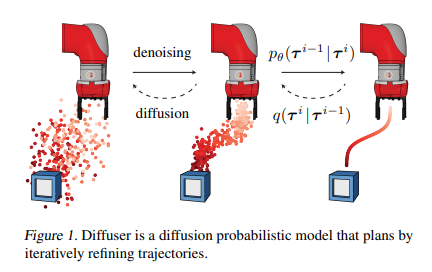

In [ ]:
from IPython.display import Image
Image(filename='diffusers.png')

The natural solution to tackle the problem is to take the entire trajectory into consideration during optimization. In other words:

$$
\max \mathcal{J}(s_0, a_0, s_1, a_1, \cdots)
$$

However, this approach becomes intractable in an autoregressive manner due to the exponentially large state space as the number of steps increases. This is where diffusion models come into play. Diffusion models can effectively capture the joint distribution of the entire trajectory. By sampling from this joint distribution, we can optimize the objective function. This concept forms the core motivation behind the paper [Planning with Diffusion Models](https://arxiv.org/pdf/2205.09991.pdf), which we will delve into for further exploration.

## 1.3 Challenges in Implementing the Approach

Implementing the approach described in the paper presents several challenges that need to be addressed. Although the paper provides a method and some experimental configurations, they do not offer general guide when designing your own diffusion planner. In our implementation, we encountered the following difficulties:

1. **Curse of Dimensionality**

   Dealing with high-dimensional optimization problems is challenging, and this problem arises in our case as well. While the authors' original implementation and methods are available, it is unclear if they will work effectively in high-dimensional spaces. The highest dimensional environment tested in their [Kuka environment](https://github.com/jannerm/diffuser/blob/kuka/scripts/rearrangment_kuka_planning_eval.py) consists of only 7 dimensions. Although their experiments provide a foundation, deploying the approach in high-dimensional spaces is not straightforward. We have faced this challenge extensively and will explore the solutions we developed.

2. **Diffusion Policy Model Experiments**

   The paper lacks details on the optimal choices and training methods for the diffusion planner. We will address the following questions to gain a better understanding:

   - What is the optimal architecture for the diffusion planner?
   - How can we evaluate and gain confidence in the performance of the planner?

3. **Processing Observation and Action Space**

   Initially, it seems reasonable to use the original observation and action spaces. However, it is unclear if this is the best choice. We will investigate the following questions:

   - How should we transform the observation and action space, and does it provide any benefits?
   - Is it possible to discard certain dimensions of the observation and action space? If so, how should we approach this?


# 2. Methods and Experiments

In this section, we will discuss the methods and experiments conducted in this report. The code for the experiments utilizes various libraries, including Gymnasium-Robotics, PyTorch, Minari, and Diffusers. The specific versions of these libraries used are as follows:

- torch==2.0.1
- torchvision==0.15.2
- plotly==5.14.1
- pandas==1.5.3
- matplotlib==3.7.1
- minari @ git+https://github.com/Farama-Foundation/Minari@2ebc53ff02d87be4f7f7c638ad04831533171844
- datasets==2.12.0
- diffusers==0.16.1
- gym==0.21.0
- gymnasium==0.28.1
- gymnasium-robotics==1.2.2
- h5py==3.8.0
- huggingface-hub==0.15.1
- tqdm==4.65.0

## 2.1 Visualization of the Environment

To begin, we will visualize the environment using Gymnasium-Robotics. Specifically, we will focus on the `Adroit-Door` environment, which is utilized in our experiments. This environment, denoted as `AdroitHandDoor-v1`, is derived from the research paper titled [Learning Complex Dexterous Manipulation with Deep Reinforcement Learning and Demonstrations](https://sites.google.com/view/deeprl-dexterous-manipulation). It is important to note that this environment is well-supported on the gymnasium-robotics platform.

In [ ]:
import numpy as np
import mediapy as media
# video gen class

class VideoBuffer:

    def __init__(self, max_len=100):
        self.max_len = max_len
        self.buffer = []

    def add(self, frame):
        if len(self.buffer) >= self.max_len:
            self.buffer.pop(0)
        self.buffer.append(frame)

    def get(self):
        return self.buffer

    def show(self):
        media.show_video(self.buffer)


In [ ]:
import gymnasium as gym


ENV_GYM = "AdroitHandRelocate-v1"
ENV_GYM = "AdroitHandDoor-v1"

env = gym.make(ENV_GYM, render_mode="rgb_array")
video_buffer = VideoBuffer(max_len=100)
env.reset()

for i in range(100):
    img = env.render()
    video_buffer.add(img)
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

env.close()

In [ ]:
video_buffer.show() # nice. all is well.

As seen above, environment is working without problem.

> Note that above behavior is from random action.

## 2.2 Preparing Expert Data

In this section, we will discuss how to prepare the expert data for training the diffusion planner model. The expert data is generated from the environment using [minari](https://minari.farama.org/main/), which is an offline RL dataset. We will specifically utilize the `door-expert-v0` dataset, which contains 1.02GB of expert data. Please note that the download process may take a few minutes.

It is important to mention that `Minari` is currently in beta and undergoing active development. Therefore, please be aware that the contents of this notebook may need adjustment in the future to accommodate any changes to the `Minari` platform.

In [ ]:
import minari

# do this only once, for some reason download_dataset doesn't cache.
ENV_MI = "door-expert-v0"
try:
    downloaded = minari.load_dataset(ENV_MI)
except:
    downloaded = minari.download_dataset(ENV_MI)

/home/user/anaconda3/envs/rg3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(f"Downloaded Dataset contains {downloaded.total_episodes} episodes.")

Downloaded Dataset contains 5000 episodes.


In [ ]:
v = downloaded.sample_episodes(5000)

In [ ]:

env = gym.make(ENV_GYM, render_mode="rgb_array")
video_buffer = VideoBuffer(max_len=100)
first_obs, _ = env.reset()

first = v[0]
for i in range(100):
    img = env.render()
    video_buffer.add(img)
    obs, reward, terminated, truncated, info = env.step(first.actions[i])
env.close()

In [ ]:
video_buffer.show()


From this, we have checked that *Minari* provided us with valuable 5000 expert-data. We will be using this dataset for training the diffusion trajectory model. Let us visualize some statistics of the data.

In [ ]:
TOTAL_EPS = downloaded.total_episodes

split_datasets = minari.split_dataset(downloaded, sizes=[TOTAL_EPS - 300, 300], seed=42)
v_train, v_test = split_datasets

total_obs = []
total_actions = []
for eps in v_train.sample_episodes(500):
    obs, actions = eps.observations, eps.actions
    total_obs.append(obs)
    total_actions.append(actions)

seq_len = actions.shape[0]

total_obs = np.concatenate(total_obs)
total_actions = np.concatenate(total_actions)

OBS_STD, OBS_MEAN = np.max(abs(total_obs), axis=0), np.mean(total_obs, axis=0)
ACT_STD, ACT_MEAN = np.max(abs(total_actions), axis=0), np.mean(total_actions, axis=0)


In [ ]:
ACT_DIM = ACT_MEAN.shape[0]
OBS_DIM = OBS_MEAN.shape[0]

JUST_ACTIONS = True

if JUST_ACTIONS:
    DIFFUSER_INPUT_DIM = ACT_DIM
else:
    DIFFUSER_INPUT_DIM = ACT_DIM + OBS_DIM
DIFFUSER_SEQ_LEN = seq_len

print(f"ACT_DIM: {ACT_DIM}, OBS_DIM: {OBS_DIM}, DIFFUSER_INPUT_DIM: {DIFFUSER_INPUT_DIM}, DIFFUSER_SEQ_LEN: {DIFFUSER_SEQ_LEN}")

ACT_DIM: 28, OBS_DIM: 39, DIFFUSER_INPUT_DIM: 28, DIFFUSER_SEQ_LEN: 200


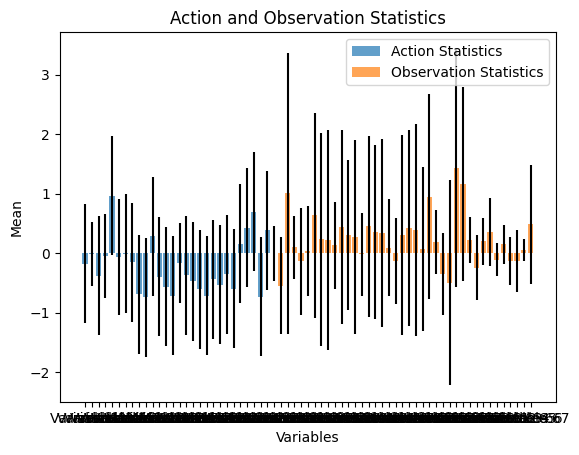

In [ ]:
# let's plot the mean, std values for obs and actions
import matplotlib.pyplot as plt
import numpy as np

N_1 = ACT_DIM
N = ACT_DIM + OBS_DIM
mean = np.concatenate([ACT_MEAN, OBS_MEAN])
std = np.concatenate([ACT_STD, OBS_STD])
action_stats = mean[:N_1]
observation_stats = mean[N_1:]
labels = ['Variable {}'.format(i) for i in range(1, N+1)]

fig, ax = plt.subplots()
ax.bar(np.arange(N_1), action_stats, yerr=std[:N_1], alpha=0.7, label='Action Statistics')
ax.bar(np.arange(N_1, N), observation_stats, yerr=std[N_1:], alpha=0.7, label='Observation Statistics')

ax.set_xlabel('Variables')
ax.set_ylabel('Mean')
ax.set_title('Action and Observation Statistics')
ax.set_xticks(np.arange(N))
ax.set_xticklabels(labels)
ax.legend()

plt.show()


Initially, we will proceed without extensive data preprocessing since the expert behavior data appears reasonably centered. However, we will later discuss the importance of other data preprocessing techniques.

# Designing the Diffusion Model

In this section, we will discuss the design of the diffusion model, specifically the Unet model, which takes the first observation as input and outputs a set of actions for the future. To implement this, we will leverage the diffusion model implementation from [diffusers](https://github.com/huggingface/diffusers).

## Model Selection

Choosing the optimal model for diffusion tasks can be challenging. Based on our experimentation, we have observed the following trends:

1. **Model Scaling**: Diffusion models are inherently counterintuitive and often require higher dimensionality. In our case, we are dealing with small-sized yet high-dimensional datasets. We found that scaling the model was necessary for it to work effectively. Surprisingly, we needed the models to be as large as *89MB* to achieve satisfactory results.

2. **Optimizer Choice**: The choice of optimizer has relatively little impact on performance. We have experimented with both Adam and SGD optimizers and found them to work well for our purposes.

3. **Model Architecture**: We utilized a Unet structure with residual skip-connections and Conv1d operations. Additionally, we incorporated a time-embedding network, as demonstrated in the diffusers paper and other relevant literature, which yielded good results.

4. **Model Layers**: The `diffusers` library provides several model layers to choose from. In our experiments, the following architecture, based on version 0.16.1, worked well. We adapted parts of the code from the [OpenAI implementation](https://github.com/openai/guided-diffusion) and a modified version from the [Huggingface Blog](https://huggingface.co/blog/annotated-diffusion).

   ```python
   FrozenDict([('sample_size', 300),
               ('sample_rate', None),
               ('in_channels', 28),
               ('out_channels', 28),
               ('extra_in_channels', 0),
               ('time_embedding_type', 'positional'),
               ('flip_sin_to_cos', True),
               ('use_timestep_embedding', True),
               ('freq_shift', 1),
               ('down_block_types',
                ['DownResnetBlock1D', 'DownResnetBlock1D', 'DownResnetBlock1D']),
               ('up_block_types', ['UpResnetBlock1D', 'UpResnetBlock1D']),
               ('mid_block_type', 'MidResTemporalBlock1D'),
               ('out_block_type', 'OutConv1DBlock'),
               ('block_out_channels', [128, 256, 512]),
               ('act_fn', 'silu'),
               ('norm_num_groups', 8),
               ('layers_per_block', 2),
               ('downsample_each_block', False)])
   ```

5. **Model Performance Evaluation**: Evaluating the performance of diffusion models can be non-trivial, particularly in terms of online performance. To assess the model's performance, we recommend the following steps:

   - Visualize the trajectory of the sampled model during experiments to ensure it follows a reasonable pattern.
   - Evaluate the model on the validation expert dataset with deterministic timesteps and noise. This provides valuable insights for tracking performance.

   This notebook contains all the necessary code for performance evaluation.

In [ ]:

from diffusers import DDPMScheduler, UNet1DModel
from diffusers.models.unet_1d import UNet1DOutput
import torch
import torch.nn as nn
from typing import Union, Optional, Tuple
import torch.nn.functional as F

from tqdm import tqdm
class UNet1dConditional(UNet1DModel):
    def __init__(
        self,
        sample_size: int = 300,
        sample_rate: Optional[int] = None,
        in_channels: int = 2,
        out_channels: int = 2,
        extra_in_channels: int = 0,
        time_embedding_type: str = "positional",
        flip_sin_to_cos: bool = True,
        use_timestep_embedding: bool = False,
        freq_shift: float = 0.0,
        down_block_types: Tuple[str] = (
            "DownBlock1DNoSkip",
            "DownBlock1D",
            "AttnDownBlock1D",
        ),
        up_block_types: Tuple[str] = ("AttnUpBlock1D", "UpBlock1D", "UpBlock1DNoSkip"),
        mid_block_type: Tuple[str] = "UNetMidBlock1D",
        out_block_type: str = None,
        block_out_channels: Tuple[int] = (64, 64, 128),
        act_fn: str = None,
        norm_num_groups: int = 8,
        layers_per_block: int = 1,
        downsample_each_block: bool = False,
        conditional_in_channels: int = 22,
        is_consistency_paramaterized = False,
        timesteps = 300, # for consistency model
        eps = 0.002, # for consistency model
    ):
        super().__init__(
            sample_size=sample_size,
            sample_rate=sample_rate,
            in_channels=in_channels,
            out_channels=out_channels,
            extra_in_channels=extra_in_channels,
            time_embedding_type=time_embedding_type,
            flip_sin_to_cos=flip_sin_to_cos,
            use_timestep_embedding=use_timestep_embedding,
            freq_shift=freq_shift,
            down_block_types=down_block_types,
            up_block_types=up_block_types,
            mid_block_type=mid_block_type,
            out_block_type=out_block_type,
            block_out_channels=block_out_channels,
            act_fn=act_fn,
            norm_num_groups=norm_num_groups,
            layers_per_block=layers_per_block,
            downsample_each_block=downsample_each_block,
        )

        self._name = "unet1d_conditional"

        self.cond_linear_proj = nn.Sequential(
            nn.Linear(conditional_in_channels, 4 * block_out_channels[0]),
            nn.ReLU(),
            nn.Linear(4 * block_out_channels[0], block_out_channels[0]),
        )

        self.trajtime_embedding = nn.Parameter(torch.randn(1, in_channels, 200))

        self.is_consistency_paramaterized = is_consistency_paramaterized
        self.timesteps = timesteps
        self.eps = eps


    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        condition: torch.FloatTensor = None,
        return_dict: bool = False,
    ) -> Union[UNet1DOutput, Tuple]:
        is_4d = False

        if len(sample.shape) == 4:
            is_4d = True
            sample = sample.squeeze(1)

        origianl_input = sample

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor(
                [timesteps], dtype=torch.long, device=sample.device
            )
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        timesteps_as_float = timesteps.float() / self.timesteps

        timestep_embed = self.time_proj(timesteps)
        if self.config.use_timestep_embedding:
            timestep_embed = self.time_mlp(timestep_embed)
        else:
            timestep_embed = timestep_embed[..., None]
            timestep_embed = timestep_embed.repeat([1, 1, sample.shape[2]]).to(
                sample.dtype
            )
            timestep_embed = timestep_embed.broadcast_to(
                (sample.shape[:1] + timestep_embed.shape[1:])
            )



        # 1.5 add condition to timestep_embed

        timestep_embed = timestep_embed + self.cond_linear_proj(condition) if condition is not None else timestep_embed

        #sample = sample + self.trajtime_embedding.repeat(sample.shape[0], 1, 1)


        # 2. down
        down_block_res_samples = ()
        for downsample_block in self.down_blocks:
            sample, res_samples = downsample_block(
                hidden_states=sample, temb=timestep_embed
            )
            down_block_res_samples += res_samples

        # 3. mid
        if self.mid_block:
            sample = self.mid_block(sample, timestep_embed)

        # 4. up
        for i, upsample_block in enumerate(self.up_blocks):
            res_samples = down_block_res_samples[-1:]
            down_block_res_samples = down_block_res_samples[:-1]
            sample = upsample_block(
                sample, res_hidden_states_tuple=res_samples, temb=timestep_embed
            )

        # 5. post-process
        if self.out_block:
            sample = self.out_block(sample, timestep_embed)

        if self.is_consistency_paramaterized:
            t = timesteps_as_float - self.eps
            print(t)
            c_skip_t = 0.25 / (t.pow(2) + 0.25)
            c_out_t = 0.25 * t / ((t + self.eps).pow(2) + 0.25).pow(0.5)

            # reshape c_skip_t and c_out_t as same size as sample

            sample = c_skip_t[:, None, None] * origianl_input + c_out_t[:, None, None] * sample


        if is_4d:
            sample = sample.unsqueeze(1)

        if not return_dict:
            return sample


        return UNet1DOutput(sample=sample)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


class DiffusionTrainer:

    def __init__(self, x_channel, condition_channel, timesteps = 1000, model_multiplier = 1):

        self.model = UNet1dConditional(
            in_channels=x_channel,
            out_channels=x_channel,
            use_timestep_embedding=True,
            time_embedding_type="positional",
            act_fn="silu",
            freq_shift=1,
            block_out_channels=[32 * model_multiplier, 64 * model_multiplier, 128 * model_multiplier],
            down_block_types=["DownResnetBlock1D", "DownResnetBlock1D", "DownResnetBlock1D"],
            up_block_types=[
                "UpResnetBlock1D",
                "UpResnetBlock1D",
            ],
            layers_per_block=2,
            mid_block_type="MidResTemporalBlock1D",
            out_block_type="OutConv1DBlock",
            conditional_in_channels=condition_channel,
        )
        self.betas = linear_beta_schedule(timesteps=timesteps)
        self.timesteps = timesteps

        alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)


    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, x_start, t, noise=None, loss_type="l1"):
        if noise is None:
            noise = torch.randn_like(x_start)

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        predicted_noise = self.model(x_noisy, t)

        if loss_type == 'l1':
            loss = F.l1_loss(noise, predicted_noise)
        elif loss_type == 'l2':
            loss = F.mse_loss(noise, predicted_noise)
        elif loss_type == "huber":
            loss = F.smooth_l1_loss(noise, predicted_noise)
        else:
            raise NotImplementedError()

        return loss

    @torch.no_grad()
    def p_sample(self, x, t, t_index):
        betas_t = extract(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        sqrt_recip_alphas_t = extract(self.sqrt_recip_alphas, t, x.shape)

        # Equation 11 in the paper
        # Use our model (noise predictor) to predict the mean
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.model(x, t) / sqrt_one_minus_alphas_cumprod_t
        )

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = extract(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            # Algorithm 2 line 4:
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def take_eular_t1_to_t2(self, x, t1, t2):

        # fully deterministic operation to take x of t1 to x of t2, using PF-ODE of
        # score model we currently have.
        # this is rather general.

        # ah yes, DDIM paper uses alpha as alpha-product here lol. Might be confusing.

        sqrt_alpha_t1 = extract(self.alphas_cumprod, t1, x.shape)
        sqrt_alpha_t2 = extract(self.alphas_cumprod, t2, x.shape)

        sqrt_one_minus_alpha_t1 = extract(self.sqrt_one_minus_alphas_cumprod, t1, x.shape)
        sqrt_one_minus_alpha_t2 = extract(self.sqrt_one_minus_alphas_cumprod, t2, x.shape)

        # Equation 12 of the paper https://arxiv.org/pdf/2010.02502.pdf.
        # we are going t1 -> t2, so t1 corresponds to t and t2 corresponds to t-1.
        # sorry if thats bit confusing. just thnk that we are returning t2.

        # since we use eta = 0, we can just..
        eps = self.model(x, t1)
        x2 = sqrt_alpha_t2 * (x - sqrt_one_minus_alpha_t1 * eps) / sqrt_alpha_t1 + sqrt_one_minus_alpha_t2 * eps

        return x2


    def ddim_sample(self, shape = (4, 28, 28), total_steps = 30):
        device = next(self.model.parameters()).device
        b = shape[0]
        init_t = self.timesteps - 1
        _sample = torch.randn(shape, device=device)
        skip_steps = self.timesteps / total_steps
        skip_steps = round(skip_steps)
        for i in tqdm(range(self.timesteps - 1, 0, -skip_steps)):

            if i - skip_steps < 0:
                next_t = 0
            else:
                next_t = i - skip_steps

            _sample = self.take_eular_t1_to_t2(_sample, torch.full((b,), i, device=device, dtype=torch.long), torch.full((b,), next_t, device=device, dtype=torch.long))

        return _sample.cpu().numpy()


    def sample(self, shape = (4, 28, 28), return_all = False):
        device = next(self.model.parameters()).device
        b = shape[0]
        # start from pure noise (for each example in the batch)
        _sample = torch.randn(shape, device=device)
        _samples = []

        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=300):
            _sample = self.p_sample( _sample, torch.full((b,), i, device=device, dtype=torch.long), i)
            _samples.append(_sample.cpu().numpy())

        if return_all:
            return _samples
        return _sample.cpu().numpy()

Let's prepare training. We will use Adam optimizer and Huber loss for training. We will train the model for 100 epochs, and save the model every 10 epochs. For diffusion model, we will use linear scheduler with 300 timesteps.

In [ ]:
#from diffusion_trainer import DiffusionTrainer
import torch

trainer = DiffusionTrainer(
    x_channel=DIFFUSER_INPUT_DIM,
    condition_channel=OBS_DIM,
    timesteps=300,
    model_multiplier=4,
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
trainer.model.to(device)
from torch.optim import Adam

optimizer = Adam(trainer.model.parameters(), lr=1e-3)


In [ ]:

from torch.utils.data import Dataset, DataLoader
import torch
from diffusers.utils import randn_tensor

SCALAR = 4.0
DO_TRANSFORM = False

if DO_TRANSFORM:
    SCALAR = 1.0

class TrajectoryConditionalScoreDataset(Dataset):

    def __init__(self, dataset, deterministic=False, timesteps = 300, obs_std = OBS_STD, obs_mean = OBS_MEAN,
                 actions_std = ACT_STD, action_mean = ACT_MEAN, just_actions = JUST_ACTIONS, do_transform = DO_TRANSFORM):
        dataset.set_seed(42)
        self.offline_env = dataset.sample_episodes(dataset.total_episodes)
        self.deterministic = deterministic
        self.timesteps = timesteps
        self.just_actions = just_actions

        self.do_transform = do_transform

        self.obs_std = torch.tensor(obs_std)
        self.obs_mean = torch.tensor(obs_mean)
        self.actions_std = torch.tensor(actions_std)
        self.action_mean = torch.tensor(action_mean)


    def __len__(self):
        return len(self.offline_env)

    def __getitem__(self, idx):
        episode = self.offline_env[idx]
        init_obs = torch.tensor(episode.observations[0])
        next_obs = torch.tensor(episode.observations[1:])
        actions = torch.tensor(episode.actions)

        if self.do_transform:
            init_obs = (init_obs - self.obs_mean) / self.obs_std
            next_obs = (next_obs - self.obs_mean) / self.obs_std
            actions = (actions - self.action_mean) / self.actions_std


        # make it [, H, T]
        if self.just_actions:
            output_concat = actions.transpose(0, 1).contiguous()
        else:
            output_concat = torch.cat([next_obs, actions], dim=-1).transpose(0, 1).contiguous()

        if self.do_transform:
            OS = 1
            # smooth output_concat in time dimension
            output_concat[ :, OS + 1:-1] = (output_concat[ :, OS:-2] + 2 * output_concat[ :, OS + 1:-1] + output_concat[ :, OS + 2:]) / 4.0


        if self.deterministic:
            time = torch.tensor(idx % self.timesteps)
            gen = torch.Generator("cpu")
            gen.manual_seed(42)
            noise = randn_tensor(output_concat.shape, generator=gen, device=output_concat.device, dtype=output_concat.dtype)
        else:
            time = torch.randint(0, self.timesteps, (1,))
            noise = torch.randn_like(output_concat)


        return init_obs, output_concat * SCALAR, time, noise

train_dl = DataLoader(TrajectoryConditionalScoreDataset(v_train, deterministic=False), batch_size=128, shuffle=True)
val_dl = DataLoader(TrajectoryConditionalScoreDataset(v_test, deterministic=True), batch_size=128, shuffle=False)


In [ ]:
cond, x, t, noise = next(iter(val_dl))
print(cond.shape, x.shape, t.shape, noise.shape)


torch.Size([128, 39]) torch.Size([128, 28, 200]) torch.Size([128]) torch.Size([128, 28, 200])


In [ ]:
import torch.nn.functional as F
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 25

val_losses = []

for epoch in range(num_epochs):
    pbar = tqdm(train_dl)
    for cond, x, t, noise in pbar:


        cond, x, t, noise = cond.float().cuda(), x.float().cuda(), t.long().cuda(), noise.float().cuda()
        t = t.squeeze()

        loss = trainer.p_losses(x, t, loss_type="huber")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.set_description(f"Epoch {epoch} Loss {loss.item()}")

    # validate
    total_loss = 0.0
    bs = 0
    with torch.no_grad():
        for cond, x, t, noise in val_dl:
            cond, x, t, noise = cond.float().cuda(), x.float().cuda(), t.long().cuda(), noise.float().cuda()
            t = t.squeeze()
            loss = trainer.p_losses( x, t, loss_type="huber")
            bs += x.shape[0]

            total_loss += loss.item()

    print(f"Epoch {epoch} Val Loss {total_loss / bs:.4f}")
    val_losses.append(total_loss / bs)


In [ ]:

if DO_TRANSFORM is False:
    torch.save(val_losses, f"val_losses_{ENV_GYM}_{JUST_ACTIONS}.pt")
    torch.save(trainer.model.state_dict(), f"model_{ENV_GYM}_{JUST_ACTIONS}.pt")
else:
    torch.save(val_losses, f"val_losses_{ENV_GYM}_{JUST_ACTIONS}_transformed.pt")
    torch.save(trainer.model.state_dict(), f"model_{ENV_GYM}_{JUST_ACTIONS}_transformed.pt")

# 3. Results


## 3.1 Diffusion model struggles with high-dimensional action-observation space


# 3. Results

## 3.1 Diffusion Model Challenges in High-Dimensional Action-Observation Space

It is well-known in machine learning that high-capacity models struggle to generalize effectively when faced with high-dimensional data. This issue is commonly referred to as the "curse of dimensionality."

Now, let's consider the dimensionality of our specific problem, which is diffusion-trajectory modeling. Our objective is to model the *joint distribution* of the entire trajectory, leading to the following dimensionality:

$$
\text{dim}(\text{trajectory}) = (\text{dim}(\text{observation}) + \text{dim}(\text{action})) \times \text{timesteps}
$$

In our case, this translates to:

$$
\text{dim}(\text{trajectory}) = (28 + 39) \times 200 = 13400
$$

The dimensionality of 13400 is exceptionally high for this task. One might not think this, as CIFAR-10 dataset is also relatively large, yet, well-solved task.

However, our problem is more challenging than working with the CIFAR-10 dataset for several reasons:

1. **Absence of Convolution Prior:** Unlike convolutional neural networks that benefit from spatial locality prior through convolutional filters, our model lacks such a prior on the feature dimensional axis (action + observation dimension). Consequently, our model must learn the entire joint distribution of the trajectory without any prior knowledge of the feature space.

2. **Limited Data with Increased Dimensionality:** We have only 5k data points, which is significantly less than the 50k training data points in CIFAR-10. Despite having 10 times less data, our dimensionality is 4 times larger. According to the Vapnik-Chervonenkis theory [5], the VC-dimension of the hypothesis should be roughly proportional to the dimensionality of the data. Thus, our problem becomes significantly more challenging.

    $$
    R(h) - R_{emp}(h) \leq O(\sqrt{d/m \log(m/d)})
    $$

3. **Causal Channelwise Dependencies:** The dependencies among channels in our trajectory are causally related, unlike CIFAR-10, which has a spatial locality prior that is non-causal and independent and identically distributed (IID). Consequently, our model needs to capture rich dependencies along the feature axis, which is not the case for CIFAR-10. For a 3-dimensional channel, there are 9 channelwise interactions, whereas for a 67-dimensional channel, there are 4489 channelwise interactions. This substantial increase in interactions poses a significant challenge.

4. **Training Time Discrepancy:** Even considering all the aforementioned difficulties, CIFAR-10 models are typically trained for tens of hours [13].

Now, let's move on to visualizing the results of the diffusion model.

In [ ]:
def evaluate_sample(sample):
    env = gym.make(ENV_GYM, render_mode="rgb_array")
    video_buffer = VideoBuffer(max_len=300)
    first_obs, _ = env.reset()
    first_obs = torch.tensor(first_obs).float().cuda().unsqueeze(0)

    reward_sum = 0.0

    first = v[0]
    for i in range(200):
        img = env.render()
        video_buffer.add(img)

        action = sample[0, -ACT_DIM:, i]
        if isinstance(action, torch.Tensor):
            action = action.cpu().numpy()

        obs, reward, terminated, truncated, info = env.step(action)
        reward_sum += reward

    env.close()
    print(f"Reward Sum: {reward_sum}")
    video_buffer.show()


In [ ]:
if JUST_ACTIONS is False:
    sampled = trainer.sample(shape=(1, DIFFUSER_INPUT_DIM, DIFFUSER_SEQ_LEN))
    sampled = sampled / SCALAR
    evaluate_sample(sampled)

sampling loop time step: 100%|██████████| 300/300 [00:01<00:00, 266.35it/s]


Reward Sum: -45.89651208209285


It is not surprising that the diffusion planner has not learned anything, considering that we have previously discussed the inherent challenges of the problem. To gain further insights into the issue, we can visualize the set of actuator state and observation data obtained from expert offline data.

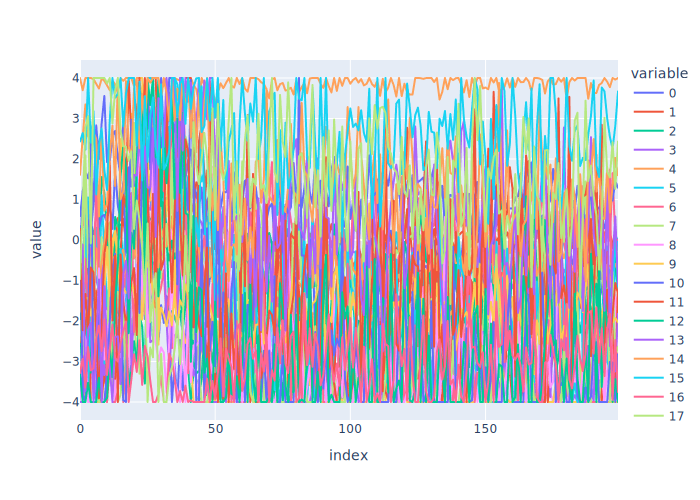

In [ ]:
cond, x, t, noise = next(iter(train_dl))

import plotly.express as px
action = x[0, 2:, :]

px.line(x[0,:].T).show(renderer = "svg")

Not only are the data *high dimensional*, *temporally correlated*, but is also *very noisy*. This is not surprising, but is problematic for the diffusion model to easily learn **unlike the task described in the paper**.

# 4. Proposed Solutions

After conducting initial experiments, we discovered multiple solutions to address the problem at hand. We will explore the following solutions:

1. **Observation Reduction**

In this approach, we discard the observation space entirely and focus solely on learning the action space. By doing so, we significantly reduce the dimensionality of the problem to 39. This simplification makes the task much more manageable for the model.

To implement this solution, we can rerun the environment using a diffusion model that only samples the sequence of actions. By applying diffusion modelling specifically to the action space, we can observe improved learning results compared to the previous approach.

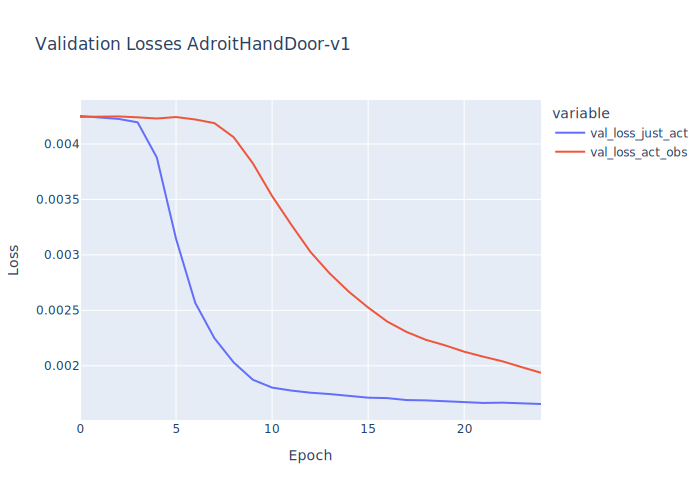

In [ ]:
import torch
import pandas as pd

val_loss_just_act = torch.load(f"val_losses_{ENV_GYM}_{True}.pt")
val_loss_act_obs = torch.load(f"val_losses_{ENV_GYM}_{False}.pt")



df = pd.DataFrame({
    "val_loss_just_act": val_loss_just_act,
    "val_loss_act_obs": val_loss_act_obs,
})

px.line(df, title=f"Validation Losses {ENV_GYM}", labels={"index": "Epoch", "value": "Loss"}).show(renderer="svg")

In [ ]:
if JUST_ACTIONS is True:
    sampled = trainer.sample(shape=(1, DIFFUSER_INPUT_DIM, DIFFUSER_SEQ_LEN))
    sampled = sampled / SCALAR
    evaluate_sample(sampled)

sampling loop time step: 100%|██████████| 300/300 [00:01<00:00, 286.65it/s]


Reward Sum: -42.61143627779942


The initial results are quite promising, indicating that the model has successfully learned to grasp the door and achieved a partial opening. However, it is evident that the model lacks confidence in predicting the trajectory, resulting in an incomplete door opening. This outcome is expected considering the limited training data of only 5,000 samples and the high dimensionality of the problem.


**Action Space Transformation**

To improve the learning process and enhance the model's ability to generalize, we propose a transformation of the action space. This transformation aims to make the action space more compact and easier to handle, similar to dimensionality reduction techniques. Our rationale for this transformation is based on the observation that the datapoints in the action space may contain significant noise, which can hinder the model's performance.

To validate our argument, we follow these steps:

1. Normalize the actions: We normalize the actions by scaling them to have a mean of 0 and a standard deviation of 1. This normalization ensures that all actions carry equal weight during training and prevents issues arising from widely varying scales. Although the impact of scale differences might be minimal, we acknowledge the benefits of this normalization step.

2. Smoothing the trajectory: We apply a simple averaging kernel to smooth the trajectory. Specifically, we utilize a (1, 2, 1) kernel for ease of calculation. Smoothing the trajectory helps to reduce the noise present in the training data. By providing a smoother trajectory, the model can focus on learning the underlying patterns without being overwhelmed by the noisy fluctuations.

By performing these action space transformations, we aim to facilitate the learning process, enhance the model's ability to generalize, and improve overall performance.

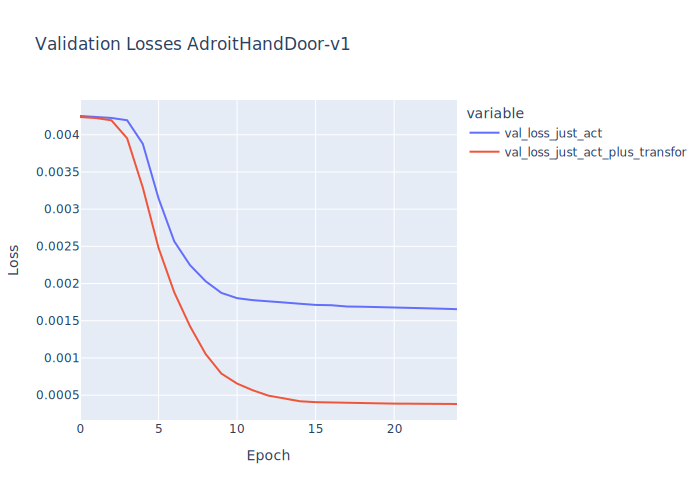

In [ ]:

val_loss_just_act = torch.load(f"val_losses_{ENV_GYM}_{True}.pt")
val_loss_just_act_plus_transform = torch.load(f"val_losses_{ENV_GYM}_{True}_transformed.pt")

import pandas as pd
import plotly.express as px

df = pd.DataFrame({
    "val_loss_just_act": val_loss_just_act,
    "val_loss_just_act_plus_transform": val_loss_just_act_plus_transform,
})

px.line(df, title=f"Validation Losses {ENV_GYM}", labels={"index": "Epoch", "value": "Loss"}).show(renderer="svg")

We can already see that the loss is much lower than the previous case. This is because the model is now learning the *smoothed* trajectory, which is much easier to learn. Note that this is minimally impacted by the scaling, because what we are predicting is score $\epsilon$, not the actual trajectory.

In [ ]:
if DO_TRANSFORM is True:
    sampled = trainer.sample(shape=(2, DIFFUSER_INPUT_DIM, DIFFUSER_SEQ_LEN))
    evaluate_sample((sampled[:, :, :] / SCALAR)* ACT_STD[None, :, None] + ACT_MEAN[None, :, None])


sampling loop time step: 100%|██████████| 300/300 [00:01<00:00, 260.88it/s]


Reward Sum: 2913.7529736467754


One can clearly see that the smoothing trick has worked incredibly well!

# Conclusions

In conclusion, implementing diffusion models in high-dimensional action-observation spaces can be challenging. Based on our research and findings, we recommend the following guidelines for effective implementation:

1. **Track a validation-expert dataset:** It is essential to maintain a dataset with fixed timesteps and noise to assess the model's online performance in various experiments. This allows you to monitor how well the model is performing and make necessary adjustments.

2. **Consider discarding the observation space:** If the observation space is excessively high-dimensional, it may be beneficial to exclude it from the model. This simplifies the learning problem and can improve overall performance.

3. **Understand the problem dimensionality:** Gain a deep understanding of the action and observation space dimensions. This knowledge will help you devise appropriate strategies and algorithms for your specific problem.

4. **Apply denoising filters:** When dealing with noisy observation or action spaces, applying simple denoising filters along the time-axis can have a significant impact on performance. This technique can enhance the model's ability to learn and make accurate predictions.

In addition, our comprehensive notebook provides a detailed implementation of the diffusion model, offline reinforcement learning, trajectory optimization, and extensive evaluations. We have showcased a potential approach to address the challenges posed by high-dimensional action-observation spaces. We hope that this notebook serves as a valuable resource for future researchers and engineers in the field of Reinforcement learning.

# References


[1] Janner, Michael, et al. "Planning with diffusion for flexible behavior synthesis." arXiv preprint arXiv:2205.09991 (2022).

[2] Wang, Zhendong, Jonathan J. Hunt, and Mingyuan Zhou. "Diffusion policies as an expressive policy class for offline reinforcement learning." arXiv preprint arXiv:2208.06193 (2022).

[3] Chi, Cheng, et al. "Diffusion policy: Visuomotor policy learning via action diffusion." arXiv preprint arXiv:2303.04137 (2023).

[4] Pearce, Tim, et al. "Imitating human behaviour with diffusion models." arXiv preprint arXiv:2301.10677 (2023).

[5] Vapnik, Vladimir N., and A. Ya Chervonenkis. "On the uniform convergence of relative frequencies of events to their probabilities." Measures of complexity: festschrift for alexey chervonenkis (2015): 11-30.

[6] Kumar, Aviral, et al. "When should we prefer offline reinforcement learning over behavioral cloning?." arXiv preprint arXiv:2204.05618 (2022).

[7] Kumar, Aviral, et al. "Conservative q-learning for offline reinforcement learning." Advances in Neural Information Processing Systems 33 (2020): 1179-1191.

[8] Hafner, Danijar, et al. "Learning latent dynamics for planning from pixels." International conference on machine learning. PMLR, 2019.

[9] Hafner, Danijar, et al. "Mastering Diverse Domains through World Models." arXiv preprint arXiv:2301.04104 (2023).

[10] Partalas, Ioannis, Dimitris Vrakas, and Ioannis Vlahavas. "Reinforcement learning and automated planning: A survey." Artificial Intelligence for Advanced Problem Solving Techniques. IGI Global, 2008. 148-165.

[11] Aradi, Szilárd. "Survey of deep reinforcement learning for motion planning of autonomous vehicles." IEEE Transactions on Intelligent Transportation Systems 23.2 (2020): 740-759.

[12] Schrittwieser, Julian, et al. "Mastering atari, go, chess and shogi by planning with a learned model." Nature 588.7839 (2020): 604-609.

[13] Ho, Jonathan, Ajay Jain, and Pieter Abbeel. "Denoising diffusion probabilistic models." Advances in Neural Information Processing Systems 33 (2020): 6840-6851.

[14] Ulyanov, Dmitry, Andrea Vedaldi, and Victor Lempitsky. "Deep image prior." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.